In [1]:
import torch
import os
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
import random
import numpy as np

## 卷积层

    nn.Conv2d(in_channels,out_channels,kernel_size,stride=1,padding=0,dilation=1,groups=1,bias=True,pading_mode='zeros')

- 功能

    对多个二维信号进行卷积
    
- in_channels

    输入通道数
    
- out_channels

    输出通道数，等价于卷积核个数
    
- kernel_size

    卷积核步长
    
- stride
    
    步长

- padding

    填充个数

- dilation

    空洞卷积大小
    
- groups

    分组卷积设置
    
- bias

    偏置
    
- 卷积层输出大小计算公式

    $$out_{size}=\frac {in_{size}-kernel_{size}}{stride}+1$$

In [2]:
def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])

    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    if 'ToTensor' in str(transform_train):
        img_ = img_.detach().numpy() * 255

    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception("Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]) )

    return img_


def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

D:/Jupyter/工作准备/pytorch学习\cat_13.jpg
卷积前尺寸:torch.Size([1, 3, 315, 499])
卷积后尺寸:torch.Size([1, 1, 313, 497])


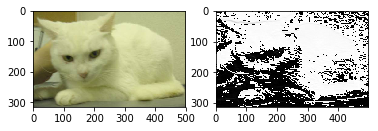

In [5]:
set_seed(3)  # 设置随机种子

# ================================= load img ==================================
path_img = os.path.join("D:/Jupyter/工作准备/pytorch学习", "cat_13.jpg")
img = Image.open(path_img).convert('RGB')  # 0~255

# convert to tensor
img_transform = transforms.Compose([transforms.ToTensor()])
img_tensor = img_transform(img)
img_tensor.unsqueeze_(dim=0)  # C*H*W to B*C*H*W

# ================================= create convolution layer ==================================

conv_layer = nn.Conv2d(3, 1, 3)  # input:(i, o, size) weights:(o, i , h, w)
nn.init.xavier_normal_(conv_layer.weight.data)
nn.init.kaiming_normal_(conv_layer.bias.data)

# calculation
img_conv = conv_layer(img_tensor)

# ================================= visualization ==================================
print("卷积前尺寸:{}\n卷积后尺寸:{}".format(img_tensor.shape, img_conv.shape))
img_conv = transform_invert(img_conv[0, 0:1, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_conv, cmap='gray')
plt.subplot(121).imshow(img_raw)
plt.show()

## 转置卷积

- 主要用来上采样

    ![](./img/zhuanzhijuan.png)

    ![](./img/zhuanzhi.png)
    
- 注意

    称为转置卷积，就是从形状上卷积核是转置的，但是对应的元素并不满足转置

    nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=1,padding=0,dilation=1,groups=1,bias=True,pading_mode='zeros')

- 功能

    对多个二维信号进行卷积
    
- in_channels

    输入通道数
    
- out_channels

    输出通道数，等价于卷积核个数
    
- kernel_size

    卷积核步长
    
- stride
    
    步长

- padding

    填充个数

- dilation

    空洞卷积大小
    
- groups

    分组卷积设置
    
- bias

    偏置
    

- 尺寸计算

    $$out_{size}=(in_{size}-1)*stride+kernel_{size}$$

https://www.jianshu.com/p/25f0139637b7

卷积前尺寸:torch.Size([1, 3, 512, 512])
卷积后尺寸:torch.Size([1, 1, 1025, 1025])


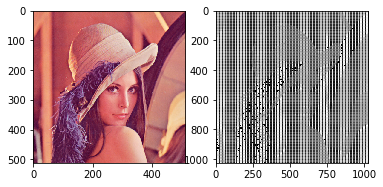

In [8]:
set_seed(3)  # 设置随机种子

# ================================= load img ==================================
path_img = os.path.join("D:/Jupyter/工作准备/pytorch学习/lesson-12", "lena.png")
img = Image.open(path_img).convert('RGB')  # 0~255

# convert to tensor
img_transform = transforms.Compose([transforms.ToTensor()])
img_tensor = img_transform(img)
img_tensor.unsqueeze_(dim=0)  # C*H*W to B*C*H*W

# ================ transposed

conv_layer = nn.ConvTranspose2d(3, 1, 3, stride=2)  # input:(i, o, size) 基本上就是通过stride值改变输入图像大小
nn.init.xavier_normal_(conv_layer.weight.data)

# calculation
img_conv = conv_layer(img_tensor)

# ================================= visualization ==================================
print("卷积前尺寸:{}\n卷积后尺寸:{}".format(img_tensor.shape, img_conv.shape))
img_conv = transform_invert(img_conv[0, 0:1, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_conv, cmap='gray')
plt.subplot(121).imshow(img_raw)
plt.show()  # 产生棋盘效应

## 池化层

    nn.MaxPool2d(kernel_size,stride=None,padding=0,dilation=1,return_indices=False,ceil_mode=False)
    
- 功能

    最大池化层
    
- kernel_size

    池化核尺寸
    
- stride

    步长
    
- dilation
    
    空洞卷积
    
- ceil_mode

    尺寸向上取整
    
- return_indices

    记录池化像素索引

池化前尺寸:torch.Size([1, 3, 512, 512])
池化后尺寸:torch.Size([1, 3, 256, 256])


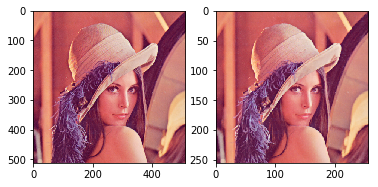

In [9]:
set_seed(1)  # 设置随机种子

# ================================= load img ==================================
path_img = os.path.join("D:/Jupyter/工作准备/pytorch学习/lesson-12", "lena.png")
img = Image.open(path_img).convert('RGB')  # 0~255

# convert to tensor
img_transform = transforms.Compose([transforms.ToTensor()])
img_tensor = img_transform(img)
img_tensor.unsqueeze_(dim=0)  # C*H*W to B*C*H*W

# ================================= create convolution layer ==================================

# ================ maxpool
maxpool_layer = nn.MaxPool2d((2, 2), stride=(2, 2))  # input:(i, o, size) weights:(o, i , h, w)
img_pool = maxpool_layer(img_tensor)
    
# ================================= visualization ==================================
print("池化前尺寸:{}\n池化后尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show() 

    nn.AvgPool2d(kernel_size,stride=None,padding=0,ceil_mode=False,count_include_pad=True,divisor_override=None)

- 功能

    平均池化层
    
- kernel_size

    池化核尺寸
    
- stride

    步长
    
- padding
    
    填充个数
    
- ceil_mode

    尺寸向上取整

- count_include_pad

    填充值用于计算
    
- divisor_override

    除法因子

池化前尺寸:torch.Size([1, 3, 512, 512])
池化后尺寸:torch.Size([1, 3, 256, 256])


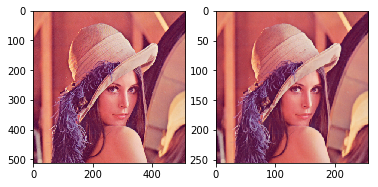

raw_img:
tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])
pooling_img:
tensor([[[[1.3333, 1.3333],
          [1.3333, 1.3333]]]])


In [11]:
set_seed(1)  # 设置随机种子

# ================================= load img ==================================
path_img = os.path.join("D:/Jupyter/工作准备/pytorch学习/lesson-12", "lena.png")
img = Image.open(path_img).convert('RGB')  # 0~255

# convert to tensor
img_transform = transforms.Compose([transforms.ToTensor()])
img_tensor = img_transform(img)
img_tensor.unsqueeze_(dim=0)  # C*H*W to B*C*H*W
# ================ avgpool
avgpoollayer = nn.AvgPool2d((2, 2), stride=(2, 2))   # input:(i, o, size) weights:(o, i , h, w)
img_pool = avgpoollayer(img_tensor)

# ================================= visualization ==================================
print("池化前尺寸:{}\n池化后尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show() 

# ================ avgpool divisor_override
img_tensor = torch.ones((1, 1, 4, 4))
avgpool_layer = nn.AvgPool2d((2, 2), stride=(2, 2), divisor_override=3) # 设置平均池化的分母
img_pool = avgpool_layer(img_tensor)

print("raw_img:\n{}\npooling_img:\n{}".format(img_tensor, img_pool))

    nn.MaxUnpool2d(kernel_size,stride=None,padding=0)
    
    forward(self,input,indices,output_size=None)

- 功能

    最大池化层上采样（反最大池化）
    
- kernel_size

    池化核尺寸
    
- stride

    步长
    
- padding
    
    填充个数
    
![](./maxpool.jpg)

In [12]:
# ================ max unpool

# pooling
img_tensor = torch.randint(high=5, size=(1, 1, 4, 4), dtype=torch.float)
maxpool_layer = nn.MaxPool2d((2, 2), stride=(2, 2), return_indices=True) # 返回最大池化层的索引
img_pool, indices = maxpool_layer(img_tensor)

# unpooling
img_reconstruct = torch.randn_like(img_pool, dtype=torch.float)
maxunpool_layer = nn.MaxUnpool2d((2, 2), stride=(2, 2))
img_unpool = maxunpool_layer(img_reconstruct, indices) # 用0补全

print("raw_img:\n{}\nimg_pool:\n{}".format(img_tensor, img_pool))
print("img_reconstruct:\n{}\nimg_unpool:\n{}".format(img_reconstruct, img_unpool))

raw_img:
tensor([[[[0., 4., 4., 3.],
          [3., 3., 1., 1.],
          [4., 2., 3., 4.],
          [1., 3., 3., 0.]]]])
img_pool:
tensor([[[[4., 4.],
          [4., 4.]]]])
img_reconstruct:
tensor([[[[-1.0276, -0.5631],
          [-0.8923, -0.0583]]]])
img_unpool:
tensor([[[[ 0.0000, -1.0276, -0.5631,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [-0.8923,  0.0000,  0.0000, -0.0583],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]]])


## 全连接层

    nn.linear(in_features,out_features,bias=True)

- 线性组合与变换

- in_features

    输入结点数
    
- out_features

    输出节点数

- bias

    是否需要偏置

In [6]:
inputs = torch.tensor([[1., 2, 3]])
w = torch.tensor([[1., 1., 1.], [2., 2., 2.], [3., 3., 3.], [4., 4., 4.]])
torch.matmul(inputs, w.T)

tensor([[ 6., 12., 18., 24.]])

In [2]:
# ================ linear

inputs = torch.tensor([[1., 2, 3]])
linear_layer = nn.Linear(3, 4)
# 自定义初始化
linear_layer.weight.data = torch.tensor([[1., 1., 1.], [2., 2., 2.],
                                         [3., 3., 3.], [4., 4., 4.]])

# linear_layer.weight.data=torch.randn((3,4))  报错  
linear_layer.bias.data.fill_(0.5)
output = linear_layer(inputs)  # W*x
print(inputs, inputs.shape)
print(linear_layer.weight.data, linear_layer.weight.data.shape)
print(output, output.shape)

tensor([[1., 2., 3.]]) torch.Size([1, 3])
tensor([[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.]]) torch.Size([4, 3])
tensor([[ 6.5000, 12.5000, 18.5000, 24.5000]], grad_fn=<AddmmBackward>) torch.Size([1, 4])


## 激活函数层

    torch.nn.Sigmoid()

    torch.nn.tanh()

    torch.nn.ReLU()

    nn.LeakyRelu()

- Negative_slope

    负半轴斜率
    
        nn.PRelu()
    
- init

    可学习斜率
    
        nn.RRelu()

- lower

    均匀分布下限

- upper

    均匀分布上限
![](./img/relu.png)

In [7]:
# ================ relu

test=torch.randn(10,5)
Fun=nn.ReLU()
out=Fun(test)
print(out)

tensor([[0.0191, 0.0000, 0.0000, 1.1803, 0.6604],
        [0.3764, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5127, 0.7828, 1.8612, 0.0000],
        [0.8357, 1.5103, 0.3583, 0.0000, 1.5004],
        [0.6164, 0.2636, 1.3514, 1.2045, 1.7031],
        [1.8699, 1.5837, 0.1280, 0.0000, 0.0000],
        [0.0000, 1.3458, 1.5614, 0.0797, 0.0000],
        [0.0481, 0.0000, 0.0000, 0.2471, 2.9032],
        [0.0000, 0.9000, 0.0000, 0.0000, 0.0000],
        [0.4755, 2.4962, 0.1026, 1.0122, 0.0000]])


## 上采样层

    torch.nn.Upsample(size=None, scale_factor=None, mode='nearest', align_corners=None)
   
- size

    上采样到指定size

- scale_factor

    指定输出为输入的多少倍数
    
- mode

    插值模式： 'nearest', 'linear', 'bilinear', 'bicubic' and 'trilinear'. 默认使用'nearest'

In [2]:
x = torch.randn((1, 4, 7, 7))
model = torch.nn.Upsample(scale_factor=2, mode='nearest')
out = model(x)
out.shape

torch.Size([1, 4, 14, 14])

In [3]:
x = torch.randn((1, 4, 7, 7))
model = torch.nn.Upsample(size=(12, 14), mode='nearest')
out = model(x)
out.shape

torch.Size([1, 4, 12, 14])